In [1]:
import shutil
from pathlib import Path
import json
from tqdm import tqdm

import torch
import nibabel as nib

from slice_inflate.datasets.clinical_cardiac_views import get_sub_sp_tensor, display_clinical_views, get_clinical_cardiac_view_affines
from slice_inflate.utils.nifti_utils import crop_around_label_center


In [2]:
C3D = "/home/weihsbach/storage/staff/christianweihsbach/c3d/c3d-1.4.0-Linux-gcc64/bin/c3d"
MMWHS_BASE_PATH = "../../data/datasets/MMWHS"


test_cases = [1007,1008] # These look very strange. better to exclude them -> perform 3-fold cross-validation
train_cases = set(range(1001,1021)) - set(test_cases)
train_cases = list(train_cases)
NUM_FOLDS = 3

assert Path(MMWHS_BASE_PATH).is_dir()

split_file_path = Path(MMWHS_BASE_PATH, 'prepared_files/metadata/data_split.json')
split_file_path.parent.mkdir(exist_ok=True, parents=True)
metadata_file_path = Path(MMWHS_BASE_PATH, 'prepared_files/metadata/metadata.json')

# Split dataset

In [3]:
if False:
    # Copy the files
    base_ct_paths = list(Path(MMWHS_BASE_PATH, 'base_files/ct_train').glob('*.nii.gz'))
    base_mr_paths = list(Path(MMWHS_BASE_PATH, 'base_files/mr_train').glob('*.nii.gz'))

    base_paths = base_ct_paths + base_mr_paths

    for p in tqdm(base_paths):
        dest_path = Path(MMWHS_BASE_PATH, 'prepared_files', p.name)
        dest_path.parent.mkdir(exist_ok=True)
        tqdm.write(f"{p} -> {dest_path}")
        shutil.copy(p, dest_path)

if False:
    # Split the copied files
    def get_fold_idxs_dict(paths):
        paths = sorted(paths)
        img_idxs = torch.arange(len(paths))[::2] # Every second path is an image

        cnks = torch.stack(torch.chunk(img_idxs, NUM_FOLDS))
        folds = []
        for f_idx in range(NUM_FOLDS):
            val_idxs = cnks.roll(f_idx, dims=0)[0]
            train_idxs = cnks.roll(f_idx, dims=0)[1:].flatten()
            folds.append((train_idxs, val_idxs))

        fold_dct = dict()
        for idx,f in enumerate(folds):
            train_idxs = sorted(f[0].tolist() + (f[0]+1).tolist())
            val_idxs = sorted(f[1].tolist() + (f[1]+1).tolist())
            fold_dct[f"fold_{idx}"] = dict(train_idxs=train_idxs, val_idxs=val_idxs)
        return fold_dct

    prepared_paths = list(Path(MMWHS_BASE_PATH, 'prepared_files').resolve().glob('*.nii.gz'))
    train_paths = sorted(filter(lambda _path: any([str(c) in str(_path) for c in train_cases]), prepared_paths))
    test_paths = sorted(filter(lambda _path: any([str(c) in str(_path) for c in test_cases]), prepared_paths))

    split_dict = dict(
        train_files=[str(p) for p in train_paths],
        train_folds=get_fold_idxs_dict(train_paths),
        test_files=[str(p) for p in test_paths]
    )

    with open(split_file_path, 'w') as f:
        json.dump(split_dict, f, indent=4)

  0%|          | 0/80 [00:00<?, ?it/s]

../../data/datasets/MMWHS/base_files/ct_train/ct_train_1013_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1013_image.nii.gz


  1%|▏         | 1/80 [00:00<00:16,  4.65it/s]

../../data/datasets/MMWHS/base_files/ct_train/ct_train_1004_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1004_image.nii.gz


  2%|▎         | 2/80 [00:00<00:16,  4.66it/s]

../../data/datasets/MMWHS/base_files/ct_train/ct_train_1004_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1004_label.nii.gz
../../data/datasets/MMWHS/base_files/ct_train/ct_train_1007_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1007_image.nii.gz


  5%|▌         | 4/80 [00:00<00:12,  6.27it/s]

../../data/datasets/MMWHS/base_files/ct_train/ct_train_1007_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1007_label.nii.gz
../../data/datasets/MMWHS/base_files/ct_train/ct_train_1008_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1008_image.nii.gz


  8%|▊         | 6/80 [00:01<00:13,  5.41it/s]

../../data/datasets/MMWHS/base_files/ct_train/ct_train_1008_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1008_label.nii.gz
../../data/datasets/MMWHS/base_files/ct_train/ct_train_1009_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1009_image.nii.gz


 10%|█         | 8/80 [00:01<00:15,  4.70it/s]

../../data/datasets/MMWHS/base_files/ct_train/ct_train_1009_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1009_label.nii.gz
../../data/datasets/MMWHS/base_files/ct_train/ct_train_1010_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1010_image.nii.gz


 12%|█▎        | 10/80 [00:02<00:14,  4.67it/s]

../../data/datasets/MMWHS/base_files/ct_train/ct_train_1010_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1010_label.nii.gz
../../data/datasets/MMWHS/base_files/ct_train/ct_train_1011_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1011_image.nii.gz


 15%|█▌        | 12/80 [00:02<00:12,  5.64it/s]

../../data/datasets/MMWHS/base_files/ct_train/ct_train_1011_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1011_label.nii.gz
../../data/datasets/MMWHS/base_files/ct_train/ct_train_1012_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1012_image.nii.gz


 18%|█▊        | 14/80 [00:02<00:12,  5.40it/s]

../../data/datasets/MMWHS/base_files/ct_train/ct_train_1012_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1012_label.nii.gz
../../data/datasets/MMWHS/base_files/ct_train/ct_train_1013_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1013_label.nii.gz
../../data/datasets/MMWHS/base_files/ct_train/ct_train_1014_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1014_image.nii.gz


 21%|██▏       | 17/80 [00:03<00:11,  5.38it/s]

../../data/datasets/MMWHS/base_files/ct_train/ct_train_1014_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1014_label.nii.gz
../../data/datasets/MMWHS/base_files/ct_train/ct_train_1015_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1015_image.nii.gz


 24%|██▍       | 19/80 [00:03<00:11,  5.16it/s]

../../data/datasets/MMWHS/base_files/ct_train/ct_train_1015_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1015_label.nii.gz
../../data/datasets/MMWHS/base_files/ct_train/ct_train_1016_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1016_image.nii.gz


 26%|██▋       | 21/80 [00:04<00:11,  5.10it/s]

../../data/datasets/MMWHS/base_files/ct_train/ct_train_1016_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1016_label.nii.gz
../../data/datasets/MMWHS/base_files/ct_train/ct_train_1017_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1017_image.nii.gz


 29%|██▉       | 23/80 [00:04<00:10,  5.24it/s]

../../data/datasets/MMWHS/base_files/ct_train/ct_train_1017_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1017_label.nii.gz
../../data/datasets/MMWHS/base_files/ct_train/ct_train_1018_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1018_image.nii.gz


 31%|███▏      | 25/80 [00:04<00:09,  5.64it/s]

../../data/datasets/MMWHS/base_files/ct_train/ct_train_1018_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1018_label.nii.gz
../../data/datasets/MMWHS/base_files/ct_train/ct_train_1019_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1019_image.nii.gz


 34%|███▍      | 27/80 [00:05<00:09,  5.71it/s]

../../data/datasets/MMWHS/base_files/ct_train/ct_train_1019_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1019_label.nii.gz
../../data/datasets/MMWHS/base_files/ct_train/ct_train_1020_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1020_image.nii.gz


 36%|███▋      | 29/80 [00:05<00:09,  5.42it/s]

../../data/datasets/MMWHS/base_files/ct_train/ct_train_1020_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1020_label.nii.gz
../../data/datasets/MMWHS/base_files/ct_train/ct_train_1001_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1001_image.nii.gz


 39%|███▉      | 31/80 [00:05<00:08,  5.46it/s]

../../data/datasets/MMWHS/base_files/ct_train/ct_train_1001_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1001_label.nii.gz
../../data/datasets/MMWHS/base_files/ct_train/ct_train_1002_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1002_image.nii.gz


 41%|████▏     | 33/80 [00:06<00:07,  6.07it/s]

../../data/datasets/MMWHS/base_files/ct_train/ct_train_1002_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1002_label.nii.gz
../../data/datasets/MMWHS/base_files/ct_train/ct_train_1003_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1003_image.nii.gz


 46%|████▋     | 37/80 [00:06<00:05,  7.21it/s]

../../data/datasets/MMWHS/base_files/ct_train/ct_train_1003_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1003_label.nii.gz
../../data/datasets/MMWHS/base_files/ct_train/ct_train_1005_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1005_image.nii.gz
../../data/datasets/MMWHS/base_files/ct_train/ct_train_1005_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1005_label.nii.gz


 46%|████▋     | 37/80 [00:06<00:05,  7.21it/s]

../../data/datasets/MMWHS/base_files/ct_train/ct_train_1006_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1006_image.nii.gz


../../data/datasets/MMWHS/base_files/ct_train/ct_train_1006_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/ct_train_1006_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1004_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1004_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1004_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1004_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1007_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1007_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1007_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1007_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1008_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1008_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1008_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1008_label

 59%|█████▉    | 47/80 [00:07<00:02, 13.74it/s]

../../data/datasets/MMWHS/base_files/mr_train/mr_train_1009_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1009_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1009_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1009_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1010_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1010_image.nii.gz


 64%|██████▍   | 51/80 [00:07<00:01, 17.24it/s]

../../data/datasets/MMWHS/base_files/mr_train/mr_train_1010_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1010_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1011_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1011_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1011_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1011_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1012_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1012_image.nii.gz


 68%|██████▊   | 54/80 [00:07<00:01, 17.63it/s]

../../data/datasets/MMWHS/base_files/mr_train/mr_train_1012_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1012_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1013_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1013_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1013_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1013_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1014_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1014_image.nii.gz


../../data/datasets/MMWHS/base_files/mr_train/mr_train_1014_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1014_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1015_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1015_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1015_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1015_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1016_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1016_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1016_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1016_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1017_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1017_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1017_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1017_label

 86%|████████▋ | 69/80 [00:08<00:00, 23.25it/s]

../../data/datasets/MMWHS/base_files/mr_train/mr_train_1018_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1018_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1019_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1019_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1019_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1019_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1020_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1020_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1020_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1020_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1001_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1001_image.nii.gz


 90%|█████████ | 72/80 [00:08<00:00, 20.88it/s]

../../data/datasets/MMWHS/base_files/mr_train/mr_train_1001_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1001_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1002_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1002_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1002_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1002_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1003_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1003_image.nii.gz


100%|██████████| 80/80 [00:08<00:00,  9.30it/s]


../../data/datasets/MMWHS/base_files/mr_train/mr_train_1003_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1003_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1005_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1005_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1005_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1005_label.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1006_image.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1006_image.nii.gz
../../data/datasets/MMWHS/base_files/mr_train/mr_train_1006_label.nii.gz -> ../../data/datasets/MMWHS/prepared_files/mr_train_1006_label.nii.gz


# Reorient MMWHS files to LPI

In [4]:
!{C3D} -version # We need at least v1.4.0

Convert3D Version 1.4.0
  Release date:      May 19, 2022
  Compile date:      Jan 13, 2023
  GIT branch:        master
  GIT commit:        feab59822240a870db021530cdb2b35dd582c871
  GIT commit date:   2022-12-20 17:21:09 -0500



In [5]:
if False:
    with open(split_file_path, 'r') as f:
        split_dict = json.load(f)

    prepared_paths = split_dict['train_files'] + split_dict['test_files']

    MMWHS_LABELS = (205,500,600,420,550) #MYO, LV, RV, LA, RA
    NEG_LABELS = (-1,-2,-3,-4,-5)
    TARGET_LABELS = (1,2,3,4,5)

    from itertools import chain, repeat

    for nii_path in tqdm(prepared_paths):
        tqdm.write(f"Processing {Path(nii_path).name}")
        if 'label' in str(nii_path):
            # Two step replacement to cut away all other classes
            neg_label_replace_str = ' '.join([str(e) for e in chain.from_iterable(zip(MMWHS_LABELS, NEG_LABELS))])
            target_label_replace_str = ' '.join([str(e) for e in chain.from_iterable(zip(NEG_LABELS, TARGET_LABELS))])
            command = \
                f"{C3D} {nii_path} " \
                f"-type int " \
                f"-interpolation NearestNeighbor -resample-mm 1x1x1mm " \
                f"-replace {neg_label_replace_str} " \
                f"-clip -inf 0 " \
                f"-replace {target_label_replace_str} " \
                f"-swapdim LPI -o {nii_path}"
            !{command}
        else:
            command = \
                f"{C3D} {nii_path} " \
                f"-type float " \
                f"-resample-mm 1x1x1mm " \
                f"-swapdim LPI -o {nii_path}"
            !{command}

  0%|          | 0/80 [00:00<?, ?it/s]

Processing ct_train_1001_image.nii.gz


  1%|▏         | 1/80 [00:11<15:02, 11.42s/it]

Processing ct_train_1001_label.nii.gz


  2%|▎         | 2/80 [00:17<10:48,  8.31s/it]

Processing ct_train_1002_image.nii.gz


  4%|▍         | 3/80 [00:31<14:07, 11.01s/it]

Processing ct_train_1002_label.nii.gz


  5%|▌         | 4/80 [00:39<12:22,  9.77s/it]

Processing ct_train_1003_image.nii.gz


  6%|▋         | 5/80 [00:47<11:34,  9.26s/it]

Processing ct_train_1003_label.nii.gz


  8%|▊         | 6/80 [00:52<09:28,  7.69s/it]

Processing ct_train_1004_image.nii.gz


  9%|▉         | 7/80 [00:59<09:06,  7.49s/it]

Processing ct_train_1004_label.nii.gz


 10%|█         | 8/80 [01:03<07:41,  6.41s/it]

Processing ct_train_1005_image.nii.gz


 11%|█▏        | 9/80 [01:14<09:05,  7.69s/it]

Processing ct_train_1005_label.nii.gz


 12%|█▎        | 10/80 [01:20<08:25,  7.22s/it]

Processing ct_train_1006_image.nii.gz


 14%|█▍        | 11/80 [01:35<10:56,  9.52s/it]

Processing ct_train_1006_label.nii.gz


 15%|█▌        | 12/80 [01:43<10:27,  9.23s/it]

Processing ct_train_1009_image.nii.gz


 16%|█▋        | 13/80 [02:00<13:00, 11.65s/it]

Processing ct_train_1009_label.nii.gz


 18%|█▊        | 14/80 [02:10<12:09, 11.05s/it]

Processing ct_train_1010_image.nii.gz


 19%|█▉        | 15/80 [02:27<13:46, 12.71s/it]

Processing ct_train_1010_label.nii.gz


 20%|██        | 16/80 [02:36<12:32, 11.75s/it]

Processing ct_train_1011_image.nii.gz


 21%|██▏       | 17/80 [02:47<11:58, 11.41s/it]

Processing ct_train_1011_label.nii.gz


 22%|██▎       | 18/80 [02:53<10:08,  9.81s/it]

Processing ct_train_1012_image.nii.gz


 24%|██▍       | 19/80 [03:04<10:12, 10.03s/it]

Processing ct_train_1012_label.nii.gz


 25%|██▌       | 20/80 [03:10<08:55,  8.92s/it]

Processing ct_train_1013_image.nii.gz


 26%|██▋       | 21/80 [03:21<09:22,  9.53s/it]

Processing ct_train_1013_label.nii.gz


 28%|██▊       | 22/80 [03:27<08:19,  8.62s/it]

Processing ct_train_1014_image.nii.gz


 29%|██▉       | 23/80 [03:37<08:23,  8.82s/it]

Processing ct_train_1014_label.nii.gz


 30%|███       | 24/80 [03:42<07:10,  7.69s/it]

Processing ct_train_1015_image.nii.gz


 31%|███▏      | 25/80 [04:03<10:44, 11.71s/it]

Processing ct_train_1015_label.nii.gz


 32%|███▎      | 26/80 [04:15<10:38, 11.83s/it]

Processing ct_train_1016_image.nii.gz


 34%|███▍      | 27/80 [04:24<09:45, 11.04s/it]

Processing ct_train_1016_label.nii.gz


 35%|███▌      | 28/80 [04:29<08:02,  9.29s/it]

Processing ct_train_1017_image.nii.gz


 36%|███▋      | 29/80 [04:50<10:54, 12.84s/it]

Processing ct_train_1017_label.nii.gz


 38%|███▊      | 30/80 [05:03<10:41, 12.82s/it]

Processing ct_train_1018_image.nii.gz


 39%|███▉      | 31/80 [05:11<09:19, 11.42s/it]

Processing ct_train_1018_label.nii.gz


 40%|████      | 32/80 [05:16<07:28,  9.34s/it]

Processing ct_train_1019_image.nii.gz


 41%|████▏     | 33/80 [05:33<09:07, 11.66s/it]

Processing ct_train_1019_label.nii.gz


 42%|████▎     | 34/80 [05:43<08:37, 11.25s/it]

Processing ct_train_1020_image.nii.gz


 44%|████▍     | 35/80 [05:55<08:33, 11.40s/it]

Processing ct_train_1020_label.nii.gz


 45%|████▌     | 36/80 [06:01<07:13,  9.86s/it]

Processing mr_train_1001_image.nii.gz


 46%|████▋     | 37/80 [06:55<16:36, 23.18s/it]

Processing mr_train_1001_label.nii.gz


 48%|████▊     | 38/80 [07:27<18:01, 25.76s/it]

Processing mr_train_1002_image.nii.gz


 49%|████▉     | 39/80 [08:10<21:09, 30.96s/it]

Processing mr_train_1002_label.nii.gz


 50%|█████     | 40/80 [08:35<19:27, 29.18s/it]

Processing mr_train_1003_image.nii.gz


 51%|█████▏    | 41/80 [08:50<16:12, 24.94s/it]

Processing mr_train_1003_label.nii.gz


 52%|█████▎    | 42/80 [09:02<13:11, 20.83s/it]

Processing mr_train_1004_image.nii.gz


 54%|█████▍    | 43/80 [09:14<11:19, 18.38s/it]

Processing mr_train_1004_label.nii.gz


 55%|█████▌    | 44/80 [09:23<09:12, 15.36s/it]

Processing mr_train_1005_image.nii.gz


 56%|█████▋    | 45/80 [09:35<08:21, 14.34s/it]

Processing mr_train_1005_label.nii.gz


 57%|█████▊    | 46/80 [09:44<07:17, 12.86s/it]

Processing mr_train_1006_image.nii.gz


 59%|█████▉    | 47/80 [10:01<07:46, 14.15s/it]

Processing mr_train_1006_label.nii.gz


 60%|██████    | 48/80 [10:12<07:03, 13.25s/it]

Processing mr_train_1009_image.nii.gz
^C


 61%|██████▏   | 49/80 [10:32<07:49, 15.14s/it]

Processing mr_train_1009_label.nii.gz


 62%|██████▎   | 50/80 [10:56<08:51, 17.72s/it]

Processing mr_train_1010_image.nii.gz


 64%|██████▍   | 51/80 [11:12<08:26, 17.48s/it]

Processing mr_train_1010_label.nii.gz


 65%|██████▌   | 52/80 [11:23<07:13, 15.48s/it]

Processing mr_train_1011_image.nii.gz


 66%|██████▋   | 53/80 [11:42<07:24, 16.48s/it]

Processing mr_train_1011_label.nii.gz


 68%|██████▊   | 54/80 [11:54<06:34, 15.18s/it]

Processing mr_train_1012_image.nii.gz


 69%|██████▉   | 55/80 [12:37<09:43, 23.36s/it]

Processing mr_train_1012_label.nii.gz


 70%|███████   | 56/80 [13:02<09:35, 23.99s/it]

Processing mr_train_1013_image.nii.gz


 71%|███████▏  | 57/80 [13:39<10:42, 27.92s/it]

Processing mr_train_1013_label.nii.gz


 72%|███████▎  | 58/80 [14:02<09:38, 26.29s/it]

Processing mr_train_1014_image.nii.gz


 74%|███████▍  | 59/80 [14:55<12:01, 34.35s/it]

Processing mr_train_1014_label.nii.gz


 75%|███████▌  | 60/80 [15:26<11:10, 33.53s/it]

Processing mr_train_1015_image.nii.gz


 76%|███████▋  | 61/80 [15:56<10:12, 32.24s/it]

Processing mr_train_1015_label.nii.gz


 78%|███████▊  | 62/80 [16:14<08:25, 28.09s/it]

Processing mr_train_1016_image.nii.gz


 79%|███████▉  | 63/80 [16:27<06:42, 23.65s/it]

Processing mr_train_1016_label.nii.gz


 80%|████████  | 64/80 [16:36<05:07, 19.25s/it]

Processing mr_train_1017_image.nii.gz


 81%|████████▏ | 65/80 [16:51<04:28, 17.88s/it]

Processing mr_train_1017_label.nii.gz


 82%|████████▎ | 66/80 [17:01<03:37, 15.50s/it]

Processing mr_train_1018_image.nii.gz


 84%|████████▍ | 67/80 [17:17<03:23, 15.65s/it]

Processing mr_train_1018_label.nii.gz


 85%|████████▌ | 68/80 [17:28<02:49, 14.12s/it]

Processing mr_train_1019_image.nii.gz


 86%|████████▋ | 69/80 [17:42<02:37, 14.30s/it]

Processing mr_train_1019_label.nii.gz


 88%|████████▊ | 70/80 [17:52<02:08, 12.83s/it]

Processing mr_train_1020_image.nii.gz


 89%|████████▉ | 71/80 [18:06<01:59, 13.26s/it]

Processing mr_train_1020_label.nii.gz


 90%|█████████ | 72/80 [18:15<01:36, 12.11s/it]

Processing ct_train_1007_image.nii.gz


 91%|█████████▏| 73/80 [18:28<01:25, 12.29s/it]

Processing ct_train_1007_label.nii.gz


 92%|█████████▎| 74/80 [18:35<01:04, 10.69s/it]

Processing ct_train_1008_image.nii.gz


 94%|█████████▍| 75/80 [18:47<00:54, 10.95s/it]

Processing ct_train_1008_label.nii.gz


 95%|█████████▌| 76/80 [18:53<00:38,  9.70s/it]

Processing mr_train_1007_image.nii.gz


 96%|█████████▋| 77/80 [19:12<00:37, 12.40s/it]

Processing mr_train_1007_label.nii.gz


 98%|█████████▊| 78/80 [19:25<00:25, 12.63s/it]

Processing mr_train_1008_image.nii.gz


 99%|█████████▉| 79/80 [19:38<00:12, 12.80s/it]

Processing mr_train_1008_label.nii.gz


100%|██████████| 80/80 [19:48<00:00, 14.86s/it]


# Extract clinical views

ct_train_1001_image


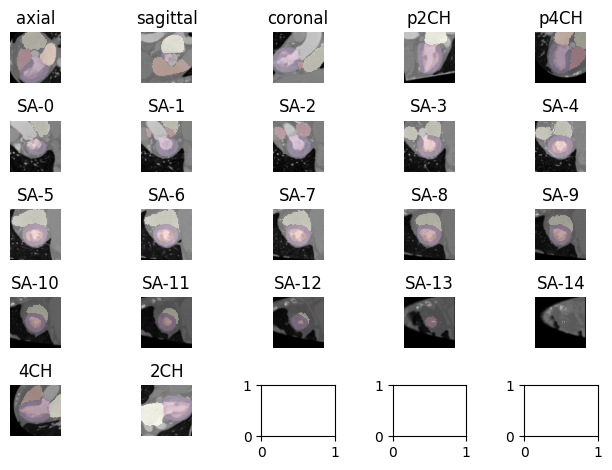



ct_train_1006_image


In [4]:
NUM_SA_SLICES = 15

class_dict = dict(
    MYO=1,
    LV=2,
    RV=3,
    LA=4,
    RA=5
)

with open(split_file_path, 'r') as f:
    split_dict = json.load(f)
prepared_paths = split_dict['train_files'] + split_dict['test_files']
metadata_dict = dict()

if False:
    FOV_MM = torch.tensor([240.,240.,240.])
    FOV_VOX = fov_vox=torch.tensor([160,160,160])

    for nii_label_path in prepared_paths:
        if not 'label' in nii_label_path: continue

        nii_image_path = nii_label_path.replace("label", "image")
        nii_label = nib.load(nii_label_path)
        nii_image = nib.load(nii_image_path)

        label = torch.as_tensor(nii_label.get_fdata()).int()
        sp_label = label.to_sparse()
        volume_affine = torch.as_tensor(nii_image.affine)
        volume = torch.as_tensor(nii_image.get_fdata())
        class_selected_sp_label = get_sub_sp_tensor(sp_label, eq_value=tuple(class_dict.values()))

        cropped_label, cropped_image, cropped_nii_affine = crop_around_label_center(
            class_selected_sp_label.to_dense()[None,None], volume_affine[None], fov_mm=FOV_MM, fov_vox=FOV_VOX,
            image=volume[None,None])

        nib.save(nib.Nifti1Image(cropped_label[0,0].int().numpy(), affine=cropped_nii_affine[0].numpy()), nii_label_path)
        nib.save(nib.Nifti1Image(cropped_image[0,0].numpy(), affine=cropped_nii_affine[0].numpy()), nii_image_path)

if True:
    display_idx = 0

    for nii_label_path in prepared_paths:
        if not 'label' in nii_label_path: continue

        nii_image_path = nii_label_path.replace("label", "image")
        nii_label = nib.load(nii_label_path)
        nii_image = nib.load(nii_image_path)

        label = torch.as_tensor(nii_label.get_fdata()).int()
        sp_label = label.to_sparse()
        volume_affine = torch.as_tensor(nii_image.affine)
        volume = torch.as_tensor(nii_image.get_fdata())

        clinical_view_affines = get_clinical_cardiac_view_affines(
            sp_label, volume_affine, class_dict, num_sa_slices=NUM_SA_SLICES, return_unrolled=True, debug=False
        )

        clinical_view_affines = {name:affine.tolist() for name,affine in clinical_view_affines.items()}

        image_id = nii_image_path.split('/')[-1].replace('.nii.gz', '')
        metadata_dict[image_id] = dict(view_affines=clinical_view_affines)

        if display_idx % 5 == 0:
            # Print every 5th sample
            print(image_id)
            display_clinical_views(volume, sp_label, volume_affine, class_dict, num_sa_slices=NUM_SA_SLICES, debug=False)
            print()
            print()

        display_idx +=1

    with open(metadata_file_path, 'w') as f:
        json.dump(metadata_dict, f, indent=4)